In [1]:
# import packages 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max

Total files in dir: 10
Total slices in stack: 10


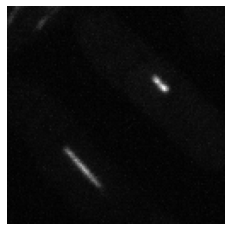

In [2]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\straight_lines_raw\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[9], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))
img = image[9]
plt.imshow(img, cmap="gray");
plt.axis("off");
# 2-4/9, 3-9, 4-2/6, 6-2/3, 7-0
# 8 multiple parallel lines 8-0/1/4

In [3]:
def hough_transform(img): 
    # initialise parameter space of all rhos and thetas
    n_y, n_x = img.shape[:]
    diag = int(np.sqrt(n_x**2 + n_y**2))

    # normalise raw data to fit in [0, 1]
    img = (img - np.min(img)) / np.max(img - np.min(img))

    # rhos range from -diagnoal to +diagonal of image 
    rhos = np.linspace(-diag, diag, 2*diag+1)
    n_rhos = len(rhos)
    # thetas range from [0, pi] or [-90, 90] radians
    thetas = np.deg2rad(np.linspace(0, 180, 180))
    n_thetas = len(thetas)

    # loop through line pixels 
    nonzeros = np.argwhere(img!=0)
    wghts = img[nonzeros[:,0], nonzeros[:,1]]

    # Hough transform: get rho results 
    x = np.array(nonzeros[:,1])
    y = np.array(nonzeros[:,0])
    n_xys = nonzeros.shape[0]

    theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
    cos_theta_mat = np.cos(theta_mult)
    sin_theta_mat = np.sin(theta_mult)
    rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)

    # get frequency of each (theta, rho) pair 
    # this is where line parameters get messed up
    accumulator, theta_vals, rho_vals = np.histogram2d(
        np.tile(thetas, rhos_res.shape[0]),
        rhos_res.ravel(), 
        bins = [n_thetas-1, n_rhos-1], 
        range = [np.deg2rad([0, 180]), [-diag, diag]],
        weights = np.repeat(wghts, n_thetas))
    return accumulator, theta_vals, rho_vals

In [4]:
# useabsolute thresholding to curate some of the lines 
def conv_via_locmax(accumulator, theta_vals, rho_vals, min_dist, min_len = 0):
    # find local maxima 
    #peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = True)
    if min_len >0: 
        peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False,
                               threshold_abs = min_len)
    else:
        peaks = peak_local_max(accumulator, min_distance = min_dist, exclude_border = False)
    n_peaks = peaks.shape[0]
    print(n_peaks, "peaks found.")

    n_x = 128
    xs = np.linspace(0, n_x-1, n_x)
    # get coordinates of line in cartesian coordinates
    rho_peaks = rho_vals[peaks[:,1]]
    theta_peaks = theta_vals[peaks[:,0]]

    cos_theta_peaks = np.cos(theta_peaks)
    sin_theta_peaks = np.sin(theta_peaks)
    # avoid sin(theta = 0) = 0 // can't divide by 0 
    sin_theta_peaks = np.where(sin_theta_peaks == 0, 0.00001, sin_theta_peaks)

    intercept = rho_peaks/sin_theta_peaks
    slope = (-cos_theta_peaks) / sin_theta_peaks
    slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 
    ys = slope_x + intercept
    
    return xs, ys, peaks, [slope, intercept]

6 peaks found.


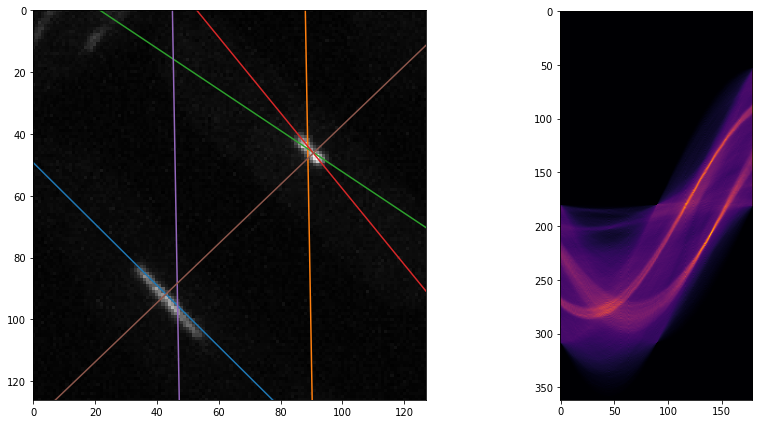

In [5]:
accumulator, theta_vals, rho_vals = hough_transform(img)
d_min = 20
l_min = 0.5 * np.max(accumulator)
xs, ys, peaks, params = conv_via_locmax(accumulator, theta_vals, rho_vals, d_min, l_min)

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize = (12,6))
fig.tight_layout()
ax[0].imshow(img, cmap="gray")
ax[0].plot(xs, ys)
ax[0].set_xlim(0,127)
ax[0].set_ylim(127-1,0);
ax[1].imshow(np.transpose(accumulator), cmap="inferno");
#ax[1].axis("off");

In [6]:
from skimage.measure import profile_line
from scipy.optimize import curve_fit

In [7]:
img = (img - np.min(img)) / np.max(img - np.min(img))

max     min    range  var   stdev
[0.1448 0.0186 0.1261 0.0005 0.0233]
[0.3865 0.014  0.3725 0.0039 0.0621]
[0.1615 0.0155 0.146  0.0009 0.0295]
[0.1276 0.0202 0.1074 0.0005 0.0219]
[0.8138 0.0133 0.8005 0.0169 0.1299]
[0.6731 0.0073 0.6658 0.01   0.1001]


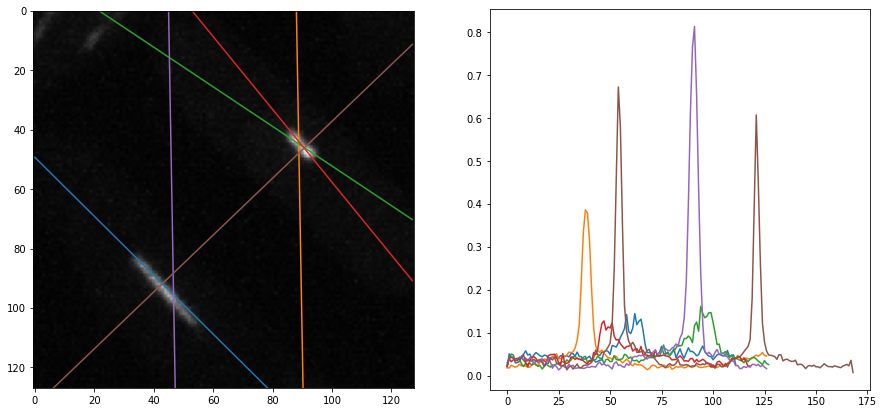

In [292]:
fix, ax = plt.subplots(1,2,figsize = (15,7))

ax[0].imshow(img, cmap="gray");
ax[0].plot(xs, ys);
ax[0].set_ylim(127,0);

print("max     min    range  var   stdev")
for i in range(6): 
    m = params[0][i]
    c = params[1][i]
    profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
    profile = profile[np.nonzero(profile)]
    print(np.around([np.max(profile), np.min(profile), 
                     np.ptp(profile), np.var(profile), np.std(profile)], 4))
    ax[1].plot(profile)

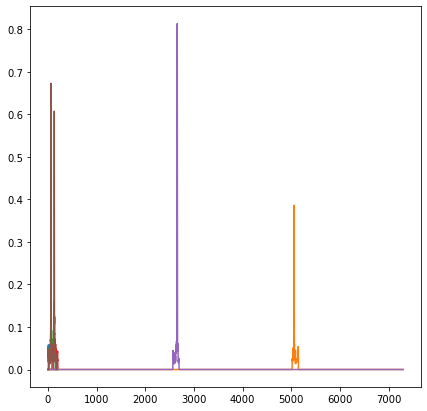

In [42]:
plt.figure(figsize=(7,7))
for i in range(6): 
    m = params[0][i]
    c = params[1][i]
    profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
    #profile = profile[np.nonzero(profile)]
    plt.plot(profile)

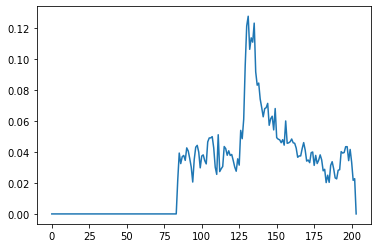

In [63]:
m = params[0][3]
c = params[1][3]
profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
profile = profile[np.nonzero(profile)]
plt.plot(profile);

In [51]:
profile.shape
#204 vs 119 
lin_prof_coord = line_profile_coordinates([0, c], [128, m*128+c])
lin_prof_coord.shape
#204 

(2, 204, 1)

In [68]:
profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
nonzero_ind = np.nonzero(profile)
x1_ind = [min_c, max_c] 
nonzero_ind[0][x1_ind] 

array([123, 146], dtype=int64)

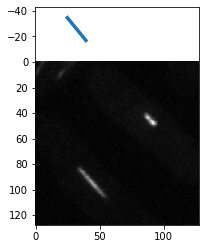

In [55]:
xind = np.linspace(1, profile.shape[0], profile.shape[0])
fit_params, fit_covs = curve_fit(gaussian, xind, profile, 
                             bounds = ([0, np.min(xind), 0, 0], 
                                       [np.inf, np.max(xind), 100, np.inf]))
fit_y = gaussian(xind, *fit_params)
fwhm = 2*np.sqrt(2*np.log(2))*fit_params[2]
lin_prof_coord = line_profile_coordinates([0, c], [128, m*128+c])
min_c = int(np.round(fit_params[1]-fwhm, 0))
max_c = int(np.round(fit_params[1]+fwhm, 0))
x1_ind = [min_c, max_c] 
x1 = lin_prof_coord[0][x1_ind]
y1 = lin_prof_coord[1][x1_ind]

plt.imshow(img, cmap="gray")
plt.plot(np.array(x1), y1, linewidth=3.5);

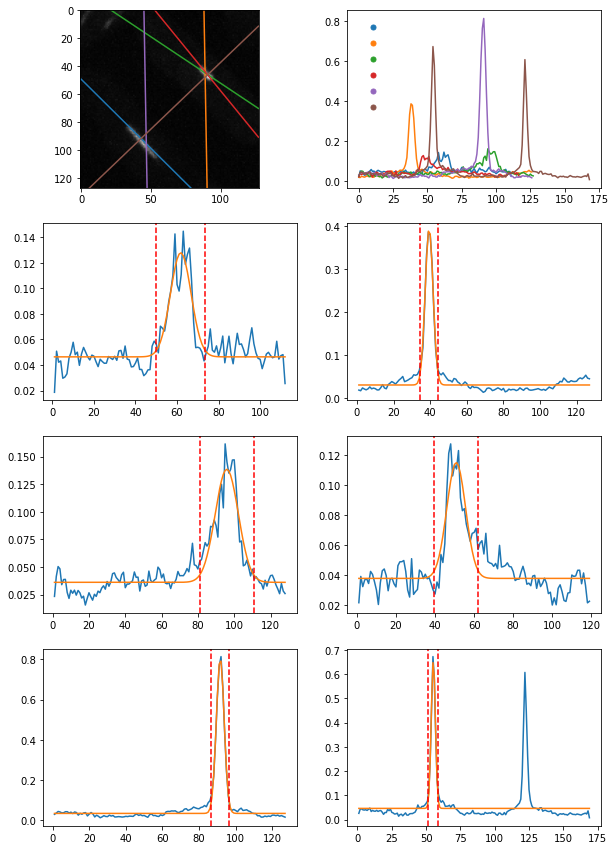

In [65]:
fig = plt.figure(figsize = (10,15))

ax = fig.add_subplot(4,2,1)
ax.imshow(img, cmap="gray");
ax.plot(xs, ys);
ax.set_ylim(127,0);

ax = fig.add_subplot(4,2,2)
for i in range(6): 
    m = params[0][i]
    c = params[1][i]
    profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
    profile = profile[np.nonzero(profile)]
    ax.plot(profile)
ax = fig.add_subplot(4,2,2)
for i in range(6):
    ax.plot(1, 0.5-(i/20), 'o', ms=5)
ax.set_ylim(0,0.55);
ax.set_xlim(0,10);
ax.axis("off");

for i in range(6): 
    m = params[0][i]
    c = params[1][i]
    profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
    profile = profile[np.nonzero(profile)]
    
    xind = np.linspace(1, profile.shape[0], profile.shape[0])
    fit_params, fit_covs = curve_fit(gaussian, xind, profile, 
                                 bounds = ([0, np.min(xind), 0, 0], 
                                           [np.inf, np.max(xind), 100, np.inf]))
    fit_y = gaussian(xind, *fit_params)
    # full width at half maximum
    fwhm = 2*np.sqrt(2*np.log(2))*fit_params[2]

    ax = fig.add_subplot(4,2,i+3)
    ax.plot(xind, np.transpose([profile, fit_y]))
    ax.axvline(x = fit_params[1]+fwhm, c="r", linestyle="--")
    ax.axvline(x = fit_params[1]-fwhm, c="r", linestyle="--")

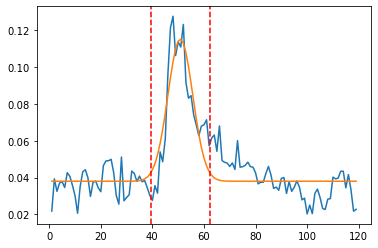

In [298]:
line_ind = 3
m = params[0][line_ind]
c = params[1][line_ind]
profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
profile = profile[np.nonzero(profile)]
xind = np.linspace(1, profile.shape[0], profile.shape[0])
fit_params, fit_covs = curve_fit(gaussian, xind, profile, bounds = ([0, np.min(xind), 0, 0], 
                                                                    [np.inf, np.max(xind), 100, np.inf]))
fit_y = gaussian(xind, *fit_params)

plt.plot(xind, profile)
plt.plot(xind, fit_y)
plt.axvline(x = fit_params[1]+fwhm, c="r", linestyle="--")
plt.axvline(x = fit_params[1]-fwhm, c="r", linestyle="--")
plt.show()

In [17]:
def line_profile_coordinates(src, dst, linewidth=1):
    src_row, src_col = src = np.asarray(src, dtype=float)
    dst_row, dst_col = dst = np.asarray(dst, dtype=float)
    d_row, d_col = dst - src
    theta = np.arctan2(d_row, d_col)

    length = int(np.ceil(np.hypot(d_row, d_col) + 1))
    # we add one above because we include the last point in the profile
    # (in contrast to standard numpy indexing)
    line_col = np.linspace(src_col, dst_col, length)
    line_row = np.linspace(src_row, dst_row, length)

    # we subtract 1 from linewidth to change from pixel-counting
    # (make this line 3 pixels wide) to point distances (the
    # distance between pixel centers)
    col_width = (linewidth - 1) * np.sin(-theta) / 2
    row_width = (linewidth - 1) * np.cos(theta) / 2
    perp_rows = np.stack([np.linspace(row_i - row_width, row_i + row_width,
                                      linewidth) for row_i in line_row])
    perp_cols = np.stack([np.linspace(col_i - col_width, col_i + col_width,
                                      linewidth) for col_i in line_col])
    return np.stack([perp_rows, perp_cols])

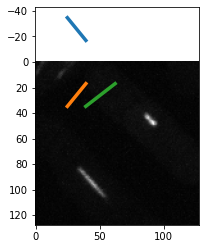

In [307]:
# full width at half maximum
fwhm = 2*np.sqrt(2*np.log(2))*fit_params[2]
lin_prof_coord = line_profile_coordinates([0, c], [128, m*128+c])
min_c = int(np.round(fit_params[1]-fwhm, 0))
max_c = int(np.round(fit_params[1]+fwhm, 0))
x1_ind = [min_c, max_c] 
x1 = lin_prof_coord[0][x1_ind]
y1 = lin_prof_coord[1][x1_ind]

plt.imshow(img, cmap="gray")
plt.plot(np.array(x1), y1, linewidth=3.5);
plt.plot(np.array(x1), abs(y1), linewidth=3.5);
plt.plot(np.array(x1_ind), abs(y1), linewidth=3.5);
#plt.xlim(0,127)
#plt.ylim(127,0);

array([], shape=(2, 0, 1), dtype=float64)

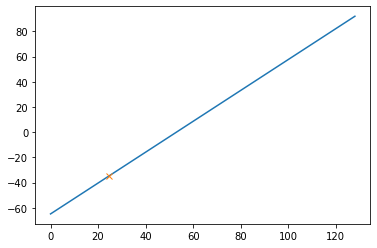

In [324]:
plt.plot(lin_prof_coord[0], lin_prof_coord[1])

plt.plot(lin_prof_coord[0][min_c], lin_prof_coord[1][min_c], "x")
#plt.xlim(0,127)
#plt.ylim(127,0);


In [330]:
lin_prof_coord[:, 0:128, int(np.round(m*128+c, 0)):128]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [354]:
np.where(lin_prof_coord[1] >0)[0][min_c]

123

In [355]:
lin_prof_coord[1][123,]

array([30.18768761])

In [341]:
lin_prof_coord[.shape

(204, 1)

In [334]:
max_c

62

In [357]:
np.where(lin_prof_coord[1] >0)[0].shape # 120 
# profile is 119

(120,)

In [53]:
#profile = profile - np.min([profile])

In [19]:
def gaussian(x, a, mu, sigma, c):
    y = a*np.exp(-(x-mu)**2/(2*sigma**2)) + c
    return y 

def get_n_peaks(line_prof):
    return len(peak_local_max(line_prof, min_distance = 5, threshold_rel = 0.5))

def get_profile(img, m, c): 
    profile = profile_line(img, [0, c], [128, m*128+c], mode='constant', cval=0, linewidth=2)
    profile = profile[np.nonzero(profile)]
    xind = np.linspace(1, profile.shape[0], profile.shape[0])
    n_peaks = get_n_peaks(profile)
    return profile, xind, n_peaks
    

In [20]:
def get_line_length_all(img, params):
    n_params = len(params[0])
    profiles, xinds, n_peaks = [0]*n_params, [0]*n_params, [0]*n_params
    gauss_params, fwhms = [0]*n_params, [0]*n_params

    for i in np.arange(n_params):
        m = params[0][i]
        c = params[1][i]
        
        profiles[i], xinds[i], n_peaks[i] = get_profile(img, m, c)
        
        fit_params, fit_covs = curve_fit(gaussian, xinds[i], profiles[i],
                                         bounds = ([0, np.min(xind), 0, 0], 
                                                   [np.inf, np.max(xind), 100, np.inf]))
        gauss_params[i] = fit_params
        fwhms[i] = 2*np.sqrt(2*np.log(2))*fit_params[2]
    
    return profiles, xinds, n_peaks, gauss_params, fwhms

In [261]:
profiles, xinds, n_peaks, gauss_params, fwhms = get_line_length(img, params)

In [21]:
def curate_lines(gauss_params, n_peaks):
    sigma_threshold = np.where(np.array(gauss_params)[:,2] > 3)
    n_peak_threshold = np.where(np.array(n_peaks) == 1)
    true_line_ind = np.intersect1d(sigma_threshold, n_peak_threshold)
    return(true_line_ind)

In [263]:
true_line_ind = curate_lines(gauss_params, n_peaks)

In [22]:
def get_line_length_curated(img, params, true_line_ind):
    n_params = len(true_line_ind)
    profiles, xinds, n_peaks = [0]*n_params, [0]*n_params, [0]*n_params
    gauss_params, fwhms, line_params = [0]*n_params, [0]*n_params, [0]*n_params

    for i in np.arange(n_params):
        ind = true_line_ind[i]
        m = params[0][ind]
        c = params[1][ind]
        
        profiles[i], xinds[i], n_peaks[i] = get_profile(img, m, c)
        
        fit_params, fit_covs = curve_fit(gaussian, xinds[i], profiles[i],
                                         bounds = ([0, np.min(xind), 0, 0], 
                                                   [np.inf, np.max(xind), 100, np.inf]))
        gauss_params[i] = fit_params
        fwhms[i] = 2*np.sqrt(2*np.log(2))*fit_params[2]
        line_params[i] = [m, c]
    
    return profiles, xinds, gauss_params, fwhms, line_params

In [281]:
profiles, xinds, gauss_params, fwhms, line_params = get_line_length_curated(img, params, true_line_ind)

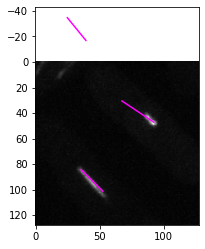

In [284]:
plt.imshow(img, cmap="gray")

for i in np.arange(len(line_params)):
    
    m = line_params[i][0]
    c = line_params[i][1]
    lin_prof_coord = line_profile_coordinates([0, c], [128, m*128+c])
    x1_ind = [int(np.round(gauss_params[i][1]-fwhms[i], 0)), int(np.round(gauss_params[i][1]+fwhms[i], 0))] 
    x1 = lin_prof_coord[0][x1_ind]
    y1 = lin_prof_coord[1][x1_ind]
    
    plt.plot(np.array(x1), y1, linewidth=1.5, c = "magenta")
    
#plt.xlim(0,127)
#plt.ylim(127,0);